<a href="https://colab.research.google.com/github/lsellers11/Quantum/blob/main/antisymND.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:311: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:312: ComplexWarning: Casting complex values to real discards the imaginary part


0.5628519867272056
(48.28296715380857+0j)
(1.0650548516382246+0j)


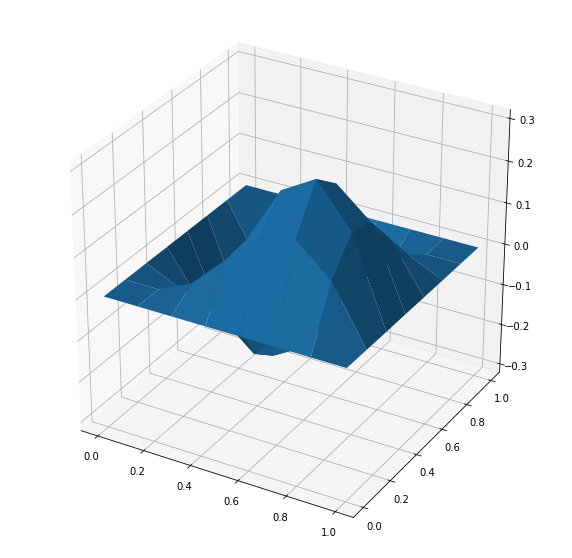

In [ ]:
import matplotlib.pyplot as plt
from sympy import *
import numpy as np
from tabulate import tabulate
import scipy.integrate as scint
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import scipy.linalg as sclalg
from mpl_toolkits.mplot3d import axes3d, Axes3D

### Grid Parameters
numevs = 1;
Lx = 1;
Nx = 8;
Ny = 8;
d = 2;
xgrid, dx = np.linspace(0, Lx, Nx, retstep=True);

### Build Mesh
N = Nx**d;
Nt = (Nx-1)**d;

### Parity Calculator
def parity(p):
  count = 0;
  d = len(p);
  for i in range(d):
    for j in range(i, d):
      if p[i] > p[j]:
        count += 1;
  return count%2;

### Check for Repeated Indices
def norepeats(p):
  L = len(p);
  thing = True;
  for i in range(L):
    for j in range(i+1, L):
      if p[i] == p[j]:
        thing = False;
  return thing;

### Node to Indices (k, j, i) Ordering Initially, Reorder Later
def node2index(n):
  indices = np.zeros(d, dtype=int);
  rems = np.zeros(d, dtype=int);
  rems[0] = n;
  for i in range(1, d):
    rem = rems[i-1]%(Nx**(d-i));
    rems[i] = rem;
  L = len(rems);
  for j in range(d-1):
    index = (rems[j] - rems[j+1]) / Nx**(d-1-j);
    indices[j] = index;
  indices[d-1] = rems[d-1];

  ##Reorder (i,j,k)
  indices = np.flip(indices);

  return indices;

### Bdry Check
def notonbdry(n):
  thing = True;
  p = node2index(n);
  for i in range(d):
    if p[i] == 0:
      thing = False;
    if p[i] == Nx-1:
      thing = False;
  return thing;

### No Repeats
def norepeats(p):
  L = len(p);
  thing = True;
  for i in range(L):
    for j in range(i+1, L):
      if p[i] == p[j]:
        thing = False;
  return thing; 

### Node from Coordinate
def nodefromcoord(p):
  L = len(p);
  n = 0;
  for i in range(L):
    n += p[i]*Nx**(i);
  return n;

### Nodes 
nodes = np.zeros((N, d));
for i in range(N):
  p = node2index(i);
  nodes[i, :] = dx*p;


### SlatNodes (Nodes with SlatnbNode index appended) (Also (i,j) as opposed to (x,y))
slatnodes = np.zeros((N, d+1), dtype=int);
slatnbcount = 0;
detnbtocoord = [];
for i in range(N):
  row = np.zeros(d+1, dtype=int);
  p = node2index(i);
  for j in range(d):
    row[j] = p[j];

  if parity(p) == 0 and notonbdry(i) and norepeats(p):
    row[d] = slatnbcount;
    slatnbcount += 1;
    detnbtocoord.append(p);
  else:
    row[d] = 0;
  
  slatnodes[i, :] = row;

detnbtocoord = np.array(detnbtocoord, dtype = int);

### Elems
elems = np.zeros((Nt, 2**d), dtype=int);
count = 0;
for t in range(Nt):
  for i in range(1, d): # Adjust Bottom Left Node 
    if t%((Nx-1)**i) == 0 and t != 0:
      count += Nx**(i-1);
  elems[t, 0] = count;
  elems[t, 1] = count+1;
  for j in range(1, d):
    for k in range(2**j):
      elems[t, 2**j + k] = elems[t, k] + Nx**j;
  count += 1;

# for t in range(Nt):
#   print(t, elems[t, :])

### Reorder for Affine Transformation

## Order p0, p1, p2, ... pn-1, pn where pn is bottom left corner

def reorderedelem(elemlist): #argument is row of elems
  # Proper Ordering 
  orderedindices = np.zeros(d+1, dtype=int);
  properorder = np.zeros(d+1, dtype=int); # Basis Nodes and bottom left corner
  for i in range(d):
    orderedindices[i] = 2**i;
    properorder[i] = elemlist[2**i];
  # Bottom Left Corner
  orderedindices[d] = 0;
  properorder[d] = elemlist[0];

  # Delete Elements from ElemList
  list2 = np.delete(elemlist, orderedindices);

  # Concatenate
  newlist = np.concatenate((properorder, list2), axis =None);

  return newlist, properorder;

### OrdElems (This defines Affine Trans Properly)
ordelems = np.zeros((Nt, 2**d), dtype=int);
for t in range(Nt):
  ordelems[t, :] = reorderedelem(elems[t, :])[0];

### Basis for Affine Transformation
properorders = np.zeros((Nt, d+1), dtype=int);
for t in range(Nt):
  properorders[t, :] = reorderedelem(elems[t, :])[1];


### Local Stiffness

def localstiffandmass(p): #(properorders[i, :], ordelems[i, :])
  
  ## Returnables
  Sel = np.zeros((2**d,2**d));
  Tel = np.zeros((2**d,2**d));

  ## B Affine Transformation 
  B = np.zeros((d,d));
  for i in range(d):
    B[:, i] = p[i, :] - p[d, :];

  # B inv
  Binv = np.linalg.inv(B);

  ## Reference N-Cube Coordinates
  u = np.zeros((2**d, d), dtype = int);
  for i in range(2**d):
    u[i, :] = np.dot(Binv, p[i, :]) - np.dot(Binv, p[d, :]);

  ## Set Local Elements for T and S
  for i in range(2**d):
    phi = u[i, :];
    for j in range(i, 2**d):
      chi = u[j, :];

      #Tel
      Tproduct = 1.0;
      SSum = 0;
      Sproducts = np.zeros(d);
      for k in range(d):

          grab = np.zeros(d); # To grab xi value
          grab[k] = 1.0;

          vector = np.ones(d); # Plug in same value for x0->xn and Transfrom
          vector0 = (1-1/3**(1/2))*vector; # 1/sqrt(3) 2 pt Quadrature
          vector1 = (1+1/3**(1/2))*vector;

          arg0 = np.dot(np.dot(B, vector0) + p[d, :], vector);
          arg1 = np.dot(np.dot(B, vector1) + p[d, :], vector);

          def phi0(x):
            if int(phi[k]) == 0:
              return 1-x;
            else:
              return x;

          def phi1(x):
            if int(chi[k]) == 0:
              return 1-x;
            else:
              return x;

          Tproduct *= (phi0(arg0)*phi1(arg0) + phi0(arg1)*phi1(arg1));
          Sproducts[k] = Tproduct  # Collect for Sel elements


      Tel[i, j] = Tproduct;
      Tel[j, i] = Tproduct;

      #Sel
      Sum = 0.0;
      for k in range(d):
        gradlist = np.arange(d);
        gradlist = np.delete(gradlist, k); # Iterate Through all DOF except k

        Sproduct = (-1.0)**(phi[k] + chi[k]);
        for m in gradlist:
          Sproduct *= Sproducts[m];

        Sum += Sproduct;

      Sel[i, j] = Sum;
      Sel[j, i] = Sum;

  return Sel, Tel;

# p = nodes[ordelems[0, :], :];
# Sel, Tel = localstiffandmass(p);

# print(Sel)
# print(Tel)

### Sparse Assembly
def spassembly(nodes, ordelems):
  spi = [];
  spj = [];
  sps = [];
  tpt = [];
  icount = 0;
  jcount = 0;
  for t in range(Nt):
    p = nodes[ordelems[t, :], :]; # p = (x, y) = dx*(i, j)
    Sel, Tel = localstiffandmass(p);
    for ti in range(2**d):
      for tj in range(2**d):
        n1 = ordelems[t, ti];
        q1 = node2index(n1);

        n2 = ordelems[t, tj];
        q2 = node2index(n2);

        if notonbdry(n1) and notonbdry(n2) and norepeats(q1) and norepeats(q2):
          slatq1 = np.sort(q1); #gives first term of slat det. Working with upper left triangle
          slatq2 = np.sort(q2);
          slatn1 = nodefromcoord(slatq1);
          slatn2 = nodefromcoord(slatq2);

          spi.append(int(slatnodes[slatn1, d])); #Gives node wrt slater basis
          spj.append(int(slatnodes[slatn2, d]));
          fact = (-1)**(parity(q1))*(-1)**(parity(q2));

          sps.append(fact*Sel[ti, tj]);
          tpt.append(fact*Tel[ti, tj]);

  spi = np.array(spi, dtype=int);
  spj = np.array(spj, dtype=int);
  sps = np.array(sps, dtype=float);
  tpt = np.array(tpt, dtype=float);

  S = sp.csc_matrix((sps, (spi, spj)), shape=(slatnbcount, slatnbcount), dtype=float);
  T = sp.csc_matrix((tpt, (spi, spj)), shape=(slatnbcount, slatnbcount), dtype=float);

  return S, T;

S, T = spassembly(nodes, ordelems);

evalues, evectors = spla.eigs(S, k = numevs, M=T, which = 'SM');

#### For 2D Check

### Expand Evectors in Grid Basis from Slat Det Basis
gridevectors = [];
for n in range(numevs):
  gridev = np.zeros((Nx, Ny));
  evector = evectors[:, n];
  for k in range(slatnbcount):
    i = int(detnbtocoord[k, 0]);
    j = int(detnbtocoord[k, 1]);
    gridev[i, j] =  evector[k];
    gridev[j, i] = -1*evector[k];
  gridevectors.append(gridev);
gridevectors = np.array(gridevectors, dtype=float);

### Exact Solutions
u10 = np.zeros(Nx*Ny);
for i in range(Nx):
  x = i*dx;
  for j in range(Ny):
    y = j*dx;
    u10[j*Nx+i] = sin(2*np.pi*x)*sin(np.pi*y) - sin(2*np.pi*y)*sin(np.pi*x);
u10 = u10 / np.linalg.norm(u10);

## Evector Vector
evectorcomp = np.zeros(Nx*Ny);
gridu10 = np.zeros((Nx, Ny));
for i in range(Nx):
  for j in range(Ny):
    evectorcomp[j*Nx+i] = gridevectors[0][i,j];
    gridu10[i,j] = u10[j*Ny+i];
evectorcomp = evectorcomp / np.linalg.norm(evectorcomp);

# ## Sign check
# p0 = evectorcomp[3];
# p1 = u10[3];
# # if p0*p1 < 0:
# #   u10 = -1*u10;
# ## Error
error = max(abs(u10-evectorcomp));
print(error)
everror = 5*np.pi**2 - evalues[0];
print(everror)
print(evalues[0])

# Plot
X, Y = np.meshgrid(xgrid, xgrid);
# xgrid = np.delete(xgrid, (0, Nx-1));
# ygrid = np.delete(ygrid, (0, Ny-1));
# for n in range(numevs):
#   X, Y = np.meshgrid(xgrid, xgrid);
#   fig = plt.figure(figsize=(10,10));
#   ax = fig.add_subplot(111, projection='3d');
#   ax.plot_surface(X, Y, gridevectors[n]);
# plt.show();

fig1 = plt.figure(figsize=(10,10));
ax1 = fig1.add_subplot(111, projection='3d');
ax1.plot_surface(X, Y, gridu10);
plt.show()
